# Neural network regression

Neural networks have become very popular recently due to the advent of high performance GPU algorithms for their application. Modern applications of neural networks often use very large networks, but in this sample we will demonstrate the possibilities using a network with a single hidden layer.

The general idea of a neural network is shown in the picture below:

<img src="../../assets/nn.png" width="50%">

Each circle represents a neuron, and the output of the neuron is calculated as shown below. In simple terms, the output of a neuron is the weighted average of its inputs, passed through what is known as an activation function. The function shown in the picture is known as a logistic or sigmoid function.

<img src="../../assets/neuron.png" width="50%">


In [1]:
import numpy
import matplotlib.pyplot as plt
%matplotlib inline

We will build our own network in this example to regress a one dimensional function. This means we will only have one input ($u$), and one output ($y$), but we can choose the number of hidden neurons. The more hidden neurons we have, the more curves we can handle in the fit function. 3 appears to be enough to do the general fits we do here without the training taking very long. There is no general rule for choosing the number of hidden neurons - use as few as possible to capture your behaviour as each new hidden neuron adds lots of weights which all have to be found.

In [55]:
Nhidden = 3

We need to create weights between each input neuron and each hidden neuron as well as each hidden neuron and each output neuron.

In [56]:
w_in_hidden = numpy.random.rand(Nhidden)
w_hidden_out = numpy.random.rand(Nhidden)

We also need a bias for the hidden layer and the output layer

In [57]:
bias_hidden = numpy.random.rand()
bias_output = numpy.random.rand()

We will use a sigmoidal activation function:

In [58]:
def sigmoid(i):
    expi = numpy.exp(-i)
    return ((1 - expi)/(1 + expi))

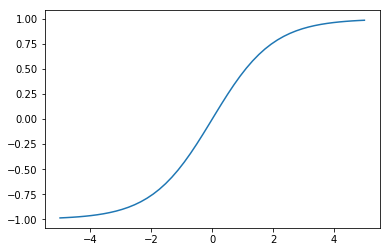

In [59]:
x = numpy.linspace(-5, 5)
plt.plot(x, sigmoid(x))

To calculate the output of a neuron, we take the weighted sum of its inputs and apply the activation function. We can do this all simulateously with numpy arrays:

In [60]:
def network_output(u, w_in_hidden, w_hidden_out, bias_hidden, bias_output):
    h = sigmoid(w_in_hidden*u + bias_hidden)
    y = sigmoid((w_hidden_out*h + bias_output).sum())
    
    return y

In [61]:
network_output(0.1, w_in_hidden, w_hidden_out, bias_hidden, bias_output)

0.4723938343512528

Let's find the weights and bias to regress a function. Due to later decisions about the final activation function which is limited to be between -1 and 1, we will limit our function to be in that range.

In [62]:
known_u = numpy.linspace(-1, 1)
known_y = numpy.sin(known_u*numpy.pi)*0.8 + numpy.random.randn(len(known_u))*0.05

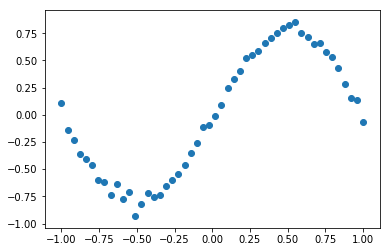

In [63]:
plt.scatter(known_u, known_y)

In [64]:
import scipy.optimize

Since we're going to use optimisation functions which take an array, we need to be able to our parameters into a single array and unpack them again.

In [65]:
def pack(w_in_hidden, w_hidden_out, bias_hidden, bias_output):
    return numpy.concatenate([w_in_hidden, 
                              w_hidden_out, 
                              numpy.array([bias_hidden]), 
                              numpy.array([bias_output])])

def unpack(parameters):
    parts = numpy.split(parameters, [Nhidden, 2*Nhidden, 2*Nhidden + 1])
    return parts

In [66]:
p0 = pack(w_in_hidden, w_hidden_out, bias_hidden, bias_output)

In [67]:
def predict(parameters, us):
    w_in_hidden, w_hidden_out, bias_hidden, bias_output = unpack(parameters)
    return numpy.array([network_output(u, w_in_hidden, w_hidden_out, bias_hidden, bias_output) for u in us])

In [68]:
def plotfit(predictions):
    plt.scatter(known_u, known_y, alpha=0.4)
    plt.plot(known_u, predictions)

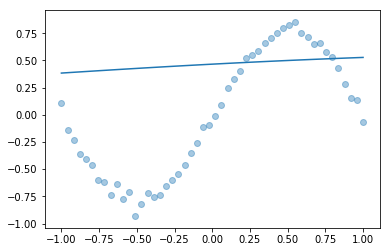

In [69]:
plotfit(predict(p0, known_u))

In [70]:
def errorfunction(parameters):
    return known_y - predict(parameters, known_u)

In [71]:
result = scipy.optimize.least_squares(errorfunction, p0)

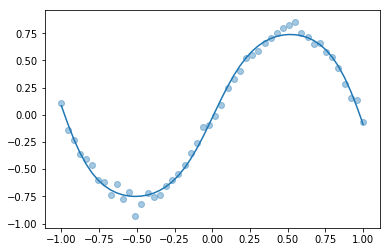

In [72]:
plotfit(predict(result.x, known_u))

## Scikit-learn

As I've mentioned before, you're probably better off using a library for things like this. The Scikit-Learn library has neural network regression built in. It is part of the standard Anaconda install.

In [44]:
import sklearn
import sklearn.neural_network

In [45]:
net = sklearn.neural_network.MLPRegressor(hidden_layer_sizes=Nhidden,
                                          activation='tanh', 
                                          solver='lbfgs', max_iter=1000, learning_rate_init=0.001)

In [46]:
observations = numpy.atleast_2d(known_u).T

In [47]:
net.fit(observations, known_y)

MLPRegressor(activation='tanh', alpha=0.0001, batch_size='auto', beta_1=0.9,
       beta_2=0.999, early_stopping=False, epsilon=1e-08,
       hidden_layer_sizes=4, learning_rate='constant',
       learning_rate_init=0.001, max_iter=1000, momentum=0.9,
       nesterovs_momentum=True, power_t=0.5, random_state=None,
       shuffle=True, solver='lbfgs', tol=0.0001, validation_fraction=0.1,
       verbose=False, warm_start=False)

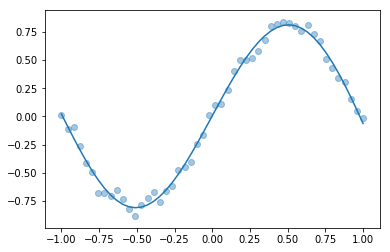

In [48]:
plotfit(net.predict(observations))

## Keras

The Keras library offers additinal flexibility, but is not installed by default in Anaconda. 

In [49]:
import keras

/Users/alchemyst/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [50]:
model = keras.models.Sequential()

In [51]:
model.add(keras.layers.Dense(Nhidden, input_shape=(1,), activation='tanh'))
model.add(keras.layers.Dense(1, activation='tanh'))

In [52]:
model.compile(optimizer='rmsprop', loss='mse')

In [53]:
model.fit(known_u, known_y, epochs=10000, verbose=False)

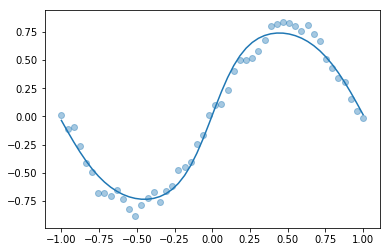

In [54]:
plotfit(model.predict(known_u))